In [3]:
%load_ext autoreload
%autoreload 2

from data_prep import DataPreparation, filtering_data
from lstm import LSTMModelTrainerAttention
from rf import RandomForestTrainer
from lgbm import LightGBMTrainer
from catboost_trainer import CatBoostTrainer
import os
import dill as pickle
import numpy as np
import pandas as pd
from analysis import plot_correlation_heatmap, get_ETO_DEP
from lstm import LSTMModelTrainerAttention, calculate_and_plot_errors#, LSTMModelTrainer

import warnings
warnings.simplefilter(action='ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
output= r'C:\Users\iLabs_6\Documents\Tex\allwithCBAS'
modelname = 'extended_df_ATOT'

 
with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_df = pickle.load(f)

extended_df['cap_DEP'].fillna(extended_df['cap_DEP'].mean(), inplace=True)
extended_df['cap_DES'].fillna(extended_df['cap_DES'].mean(), inplace=True)
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_eobt', case=False)]
extended_df = extended_df.loc[:, ~extended_df.columns.str.contains('t_to_atot', case=False)]
pd.set_option("display.max_columns", None)
X, y, colnames = filtering_data(extended_df, airport ='EHAM', save=True)
X = X.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
X.describe()

output= r'C:\Users\iLabs_6\Documents\Tex\allwithCBAS'
modelname = 'extended_df_ETOT'


with  open(os.path.join(output, modelname), 'rb') as f:  
    extended_real= pickle.load(f)
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_eobt', case=False)]
extended_real = extended_real.loc[:, ~extended_real.columns.str.contains('t_to_atot', case=False)]

pd.set_option("display.max_columns", None)
print(f'{extended_real}')
X_r, y_r, colnames = filtering_data(extended_real, airport ='EHAM', save=False)
X_r = X_r.drop(['ADES_EHAM', 'ADESLong', 'ADESLat', 'cbasentry'], axis =1)
# X.fillna(0, inplace=True)
print(f'xxxxx = {X_r}')


modelpath= r"C:\Users\iLabs_6\Documents\Tex\AirTrafficDelays\LSTM_Models"

modelname = 'lstm-9-100-2shift-2545'
# with open(os.path.join(output, modelname), 'wb') as f:  
#     pickle.dump(best_model, f, protocol=pickle.HIGHEST_PROTOCOL)
#     print(f"FlightDataset has been saved successfully. {modelname}")
###
with  open(os.path.join(modelpath, modelname), 'rb') as f:  
    best_model = pickle.load(f)

           distance                ETOT  ADEP  ADES                EOBT  \
0      14437.477905 2024-01-23 06:10:00  LSZH  EHAM 2024-01-23 05:55:00   
1       4949.190326 2024-01-23 16:05:00  EPWA  EHAM 2024-01-23 15:50:00   
2      10210.682956 2024-01-27 08:30:00  ENGM  EHAM 2024-01-27 08:20:00   
3      17013.465682 2024-01-29 05:11:00  EDDS  EHAM 2024-01-29 05:00:00   
4       4949.190326 2024-01-31 16:05:00  EPWA  EHAM 2024-01-31 15:50:00   
...             ...                 ...   ...   ...                 ...   
70709   9085.158293 2024-01-22 15:45:00  EDDF  EHAM 2024-01-22 15:30:00   
70710  12922.196222 2024-01-22 14:30:00  EFHK  EHAM 2024-01-22 14:20:00   
70711   9977.022009 2024-01-22 16:40:00  EIDW  EHAM 2024-01-22 16:20:00   
70712  14982.537341 2024-01-22 14:35:00  EKCH  EHAM 2024-01-22 14:25:00   
70713   4949.190326 2024-01-22 19:30:00  EPWA  EHAM 2024-01-22 19:15:00   

                      ETA    CDMStatus  taxitime event  regulations  \
0     2024-01-23 07:29:00  D

In [21]:
data_prep = DataPreparation()


X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, time_horizons, cbaslabels = data_prep.fit_transform_data(X, y)
X_real, ETOT_horizons, cbaslabels = data_prep.transform_data(X_r)

X_train, X_test, y_train, y_test = data_prep.fit_transform_data(X, y, split_ratio=0.8, mode='rf')


time_varying_columns=['atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 'atfmdelay_Tmin_-290', 'regulations_Tmin_-290', 'cobt_delay_Tmin_-290', 'eflighttime_Tmin_-290', 'visibility_Tmin_-290', 'ko_Tmin_-290', 'TSATdelay_Tmin_-290'

Non-zero indices in y_r: [   18    40    48 ... 70470 70500 70521]
ETOT_horizons: ['-300', '-295', '-290', '-285', '-280', '-275', '-270', '-265', '-260', '-255', '-250', '-245', '-240', '-235', '-230', '-225', '-220', '-215', '-210', '-205', '-200', '-195', '-190', '-185', '-180', '-175', '-170', '-165', '-160', '-155', '-150', '-145', '-140', '-135', '-130', '-125', '-120', '-115', '-110', '-105', '-100', '-95', '-90', '-85', '-80', '-75', '-70', '-65', '-60', '-55', '-50', '-45', '-40', '-35', '-30', '-25', '-20', '-15', '-10', '-5', '0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70', '75', '80', '85', '90', '95', '100', '105', '110', '115', '120']


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]


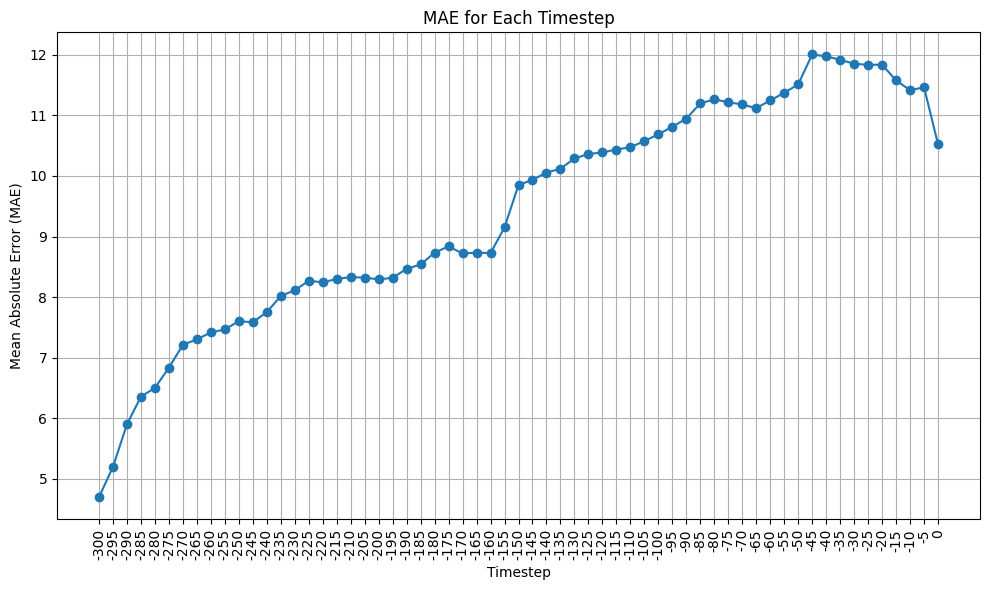

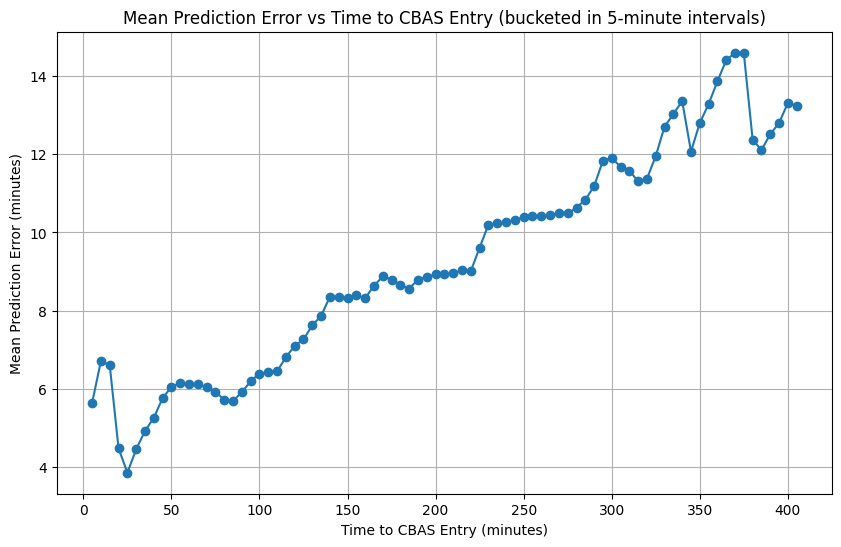

In [23]:
mae_timestep, mae_bucket = calculate_and_plot_errors(y_r, X_real, best_model, data_prep, ETOT_horizons, cbaslabels)

time_varying_columns=['t_to_atot_Tmin_-300', 'atfmdelay_Tmin_-300', 'regulations_Tmin_-300', 'cobt_delay_Tmin_-300', 'eflighttime_Tmin_-300', 'visibility_Tmin_-300', 'ko_Tmin_-300', 'TSATdelay_Tmin_-300', 'TOBTdelay_Tmin_-300', 'etodepdelay_Tmin_-300', 'timetoCBAS_Tmin_-300', 'offblock_Tmin_-300', 'fltstate_SI_Tmin_-300', 'fltstate_FI_Tmin_-300', 'fltstate_other_Tmin_-300', 'modeltyp_ACT_Tmin_-300', 'modeltyp_CAL_Tmin_-300', 'modeltyp_EST_Tmin_-300', 't_to_atot_Tmin_-295', 'atfmdelay_Tmin_-295', 'regulations_Tmin_-295', 'cobt_delay_Tmin_-295', 'eflighttime_Tmin_-295', 'visibility_Tmin_-295', 'ko_Tmin_-295', 'TSATdelay_Tmin_-295', 'TOBTdelay_Tmin_-295', 'etodepdelay_Tmin_-295', 'timetoCBAS_Tmin_-295', 'offblock_Tmin_-295', 'fltstate_SI_Tmin_-295', 'fltstate_FI_Tmin_-295', 'fltstate_other_Tmin_-295', 'modeltyp_ACT_Tmin_-295', 'modeltyp_CAL_Tmin_-295', 'modeltyp_EST_Tmin_-295', 't_to_atot_Tmin_-290', 'atfmdelay_Tmin_-290', 'regulations_Tmin_-290', 'cobt_delay_Tmin_-290', 'eflighttime_Tmin

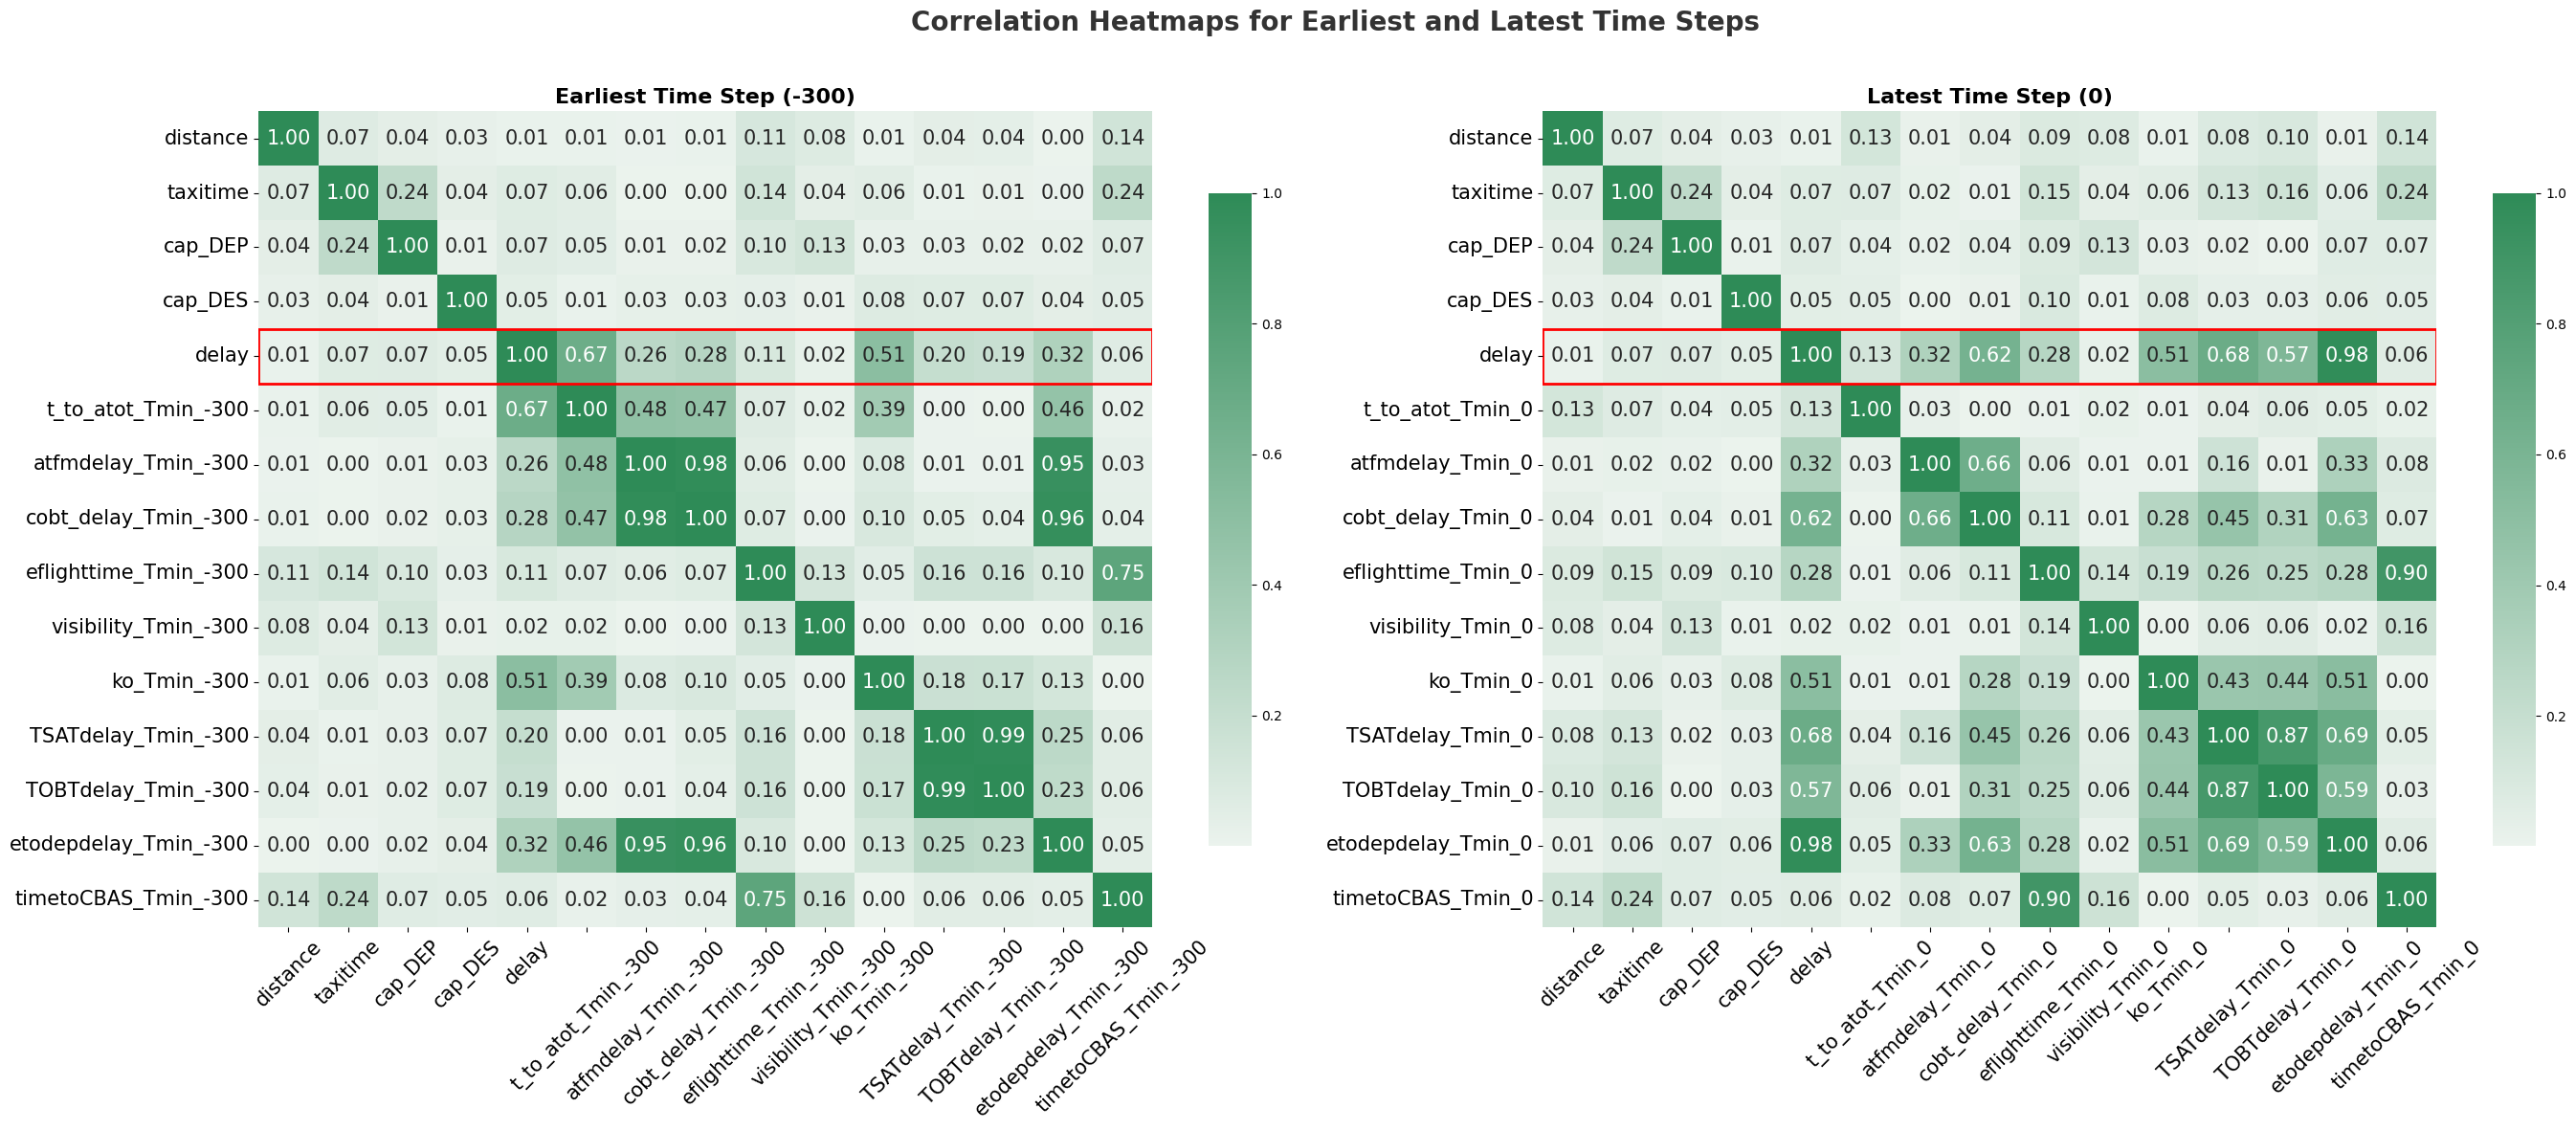

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# Plot correlation heatmaps
plot_correlation_heatmap(extended_df, include_fixed=True)

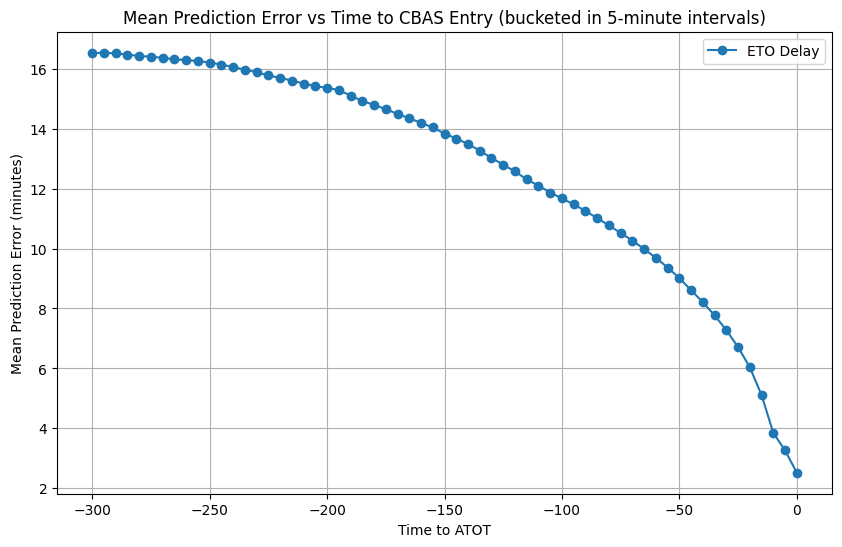

In [9]:
etodeplist = get_ETO_DEP(extended_df)

In [ ]:

bnames =data_prep.basenames
# Plot feature importance
input_size = data_prep.input_size

model_trainer = LSTMModelTrainerAttention(data_prep=data_prep, input_size=input_size, model_type='varattention')

baseline = model_trainer.compute_baseline_mae(best_model, X_test_tensor[:10000], y_test_tensor[:10000], data_prep.scaler_y, time_horizons)
imp_df = model_trainer.compute_permutation_importance(best_model, X_test_tensor[:10000], y_test_tensor[:10000], data_prep.scaler_y, time_horizons, bnames)

from sklearn.preprocessing import MinMaxScaler
def normalize_dataframe_minmax(df, feature_range=(0, 1)):
    """
    Normalize the entire DataFrame using MinMaxScaler.
    
    :param df: pandas DataFrame to normalize
    :param feature_range: tuple (min, max) desired range of transformed data
    :return: Normalized DataFrame, fitted scaler
    """
    scaler = MinMaxScaler(feature_range=feature_range)
    scaled_array = scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_array, columns=df.columns, index=df.index)
    return scaled_df, scaler

impdf2, scaler = normalize_dataframe_minmax(imp_df)
model_trainer.plot_permutation_importance(impdf2)
model_trainer.plot_permutation_importance_with_highlights_interactive(imp_df, ['ko', 'visibility','etodepdelay', 'TOBTdelay', 'TSATdelay'])